# Single Model UQ

Try to capture the input and output uncertainties for a single model in Process. This will be done by sampling the input epistemic uncertainty parameter space to the code as a whole and capturing the input distributions to the model of interest. These input distributions can then be propagated through the model of interest, and the output variance analysed. This allows the uncertainty contribution of an individual model to be assessed, given a set of epistemic uncertainty inputs for the code as a whole.

In [4]:
import easyvvuq as uq
import chaospy as cp
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Campaign to capture input distribution for `palph2()`

Using the epistemic uncertain inputs for the entire code, capture the distribution of inputs for the `palph2()` subroutine.

To start with, make just 2 inputs uncertain (for running locally).

In [5]:
# Define campaign
campaign = uq.Campaign(name="model_inputs", work_dir="campaigns")

# Define parameter space
# Uncertainties from Alex's SA paper

params = {
    "fgwped": {
        "type": "float",
        "min": 1.1,
        "max": 1.3,
        "default": 1.1,
    },  # check: not sure if this is right var
    "hfact": {"type": "float", "min": 1.0, "max": 1.2, "default": 1.1},
    "coreradius": {"type": "float", "min": 0.45, "max": 0.75, "default": 0.75},
    "fimp_2": {"type": "float", "min": 0.085, "max": 0.115, "default": 0.1},  # check
    "fimp_14": {
        "type": "float",
        "min": 1.0e-5,
        "max": 1.0e-4,
        "default": 5e-5,
    },  # check
    "psepbqarmax": {"type": "float", "min": 8.7, "max": 9.7, "default": 9.2},
    "flhthresh": {"type": "float", "min": 0.85, "max": 1.15, "default": 1.15},  # check
    "bscfmax": {"type": "float", "min": 0.95, "max": 1.05, "default": 0.99},
    "peakfactrad": {"type": "float", "min": 2.0, "max": 3.5, "default": 3.33},
    "kappa": {"type": "float", "min": 1.8, "max": 1.9, "default": 1.8},  # check default
    "etaech": {"type": "float", "min": 0.3, "max": 0.5, "default": 0.4},
    "feffcd": {"type": "float", "min": 0.5, "max": 5.0, "default": 1.0},
    "etath": {"type": "float", "min": 0.36, "max": 0.4, "default": 0.375},
    "etaiso": {"type": "float", "min": 0.75, "max": 0.95, "default": 0.9},
    "boundl_18": {
        "type": "float",
        "min": 3.25,
        "max": 3.75,
        "default": 3.5,
    },  # q^95_min
    "pinjalw": {"type": "float", "min": 51.0, "max": 61.0, "default": 51.0},
    "alstroh": {"type": "float", "min": 6.0e8, "max": 7.2e8, "default": 6.6e8},
    "sig_tf_wp_max": {
        "type": "float",
        "min": 5.2e8,
        "max": 6.4e8,
        "default": 5.8e8,
    },  # winding pack, or casing?
    "aspect": {"type": "float", "min": 3.0, "max": 3.2, "default": 3.1},
    "boundu_2": {
        "type": "float",
        "min": 11.0,
        "max": 12.0,
        "default": 11.5,
    },  # B_T^max: check default
    "triang": {"type": "float", "min": 0.4, "max": 0.6, "default": 0.5},
    "out_file": {"type": "string", "default": "out.csv"},
}

# QoIs for palph2(): inputs (args)
palph2_inputs = [
    "bt",
    "bp",
    "dene",
    "deni",
    "dnitot",
    "falpe",
    "falpi",
    "palpnb",
    "ifalphap",
    "pchargepv",
    "pneutpv",
    "ten",
    "tin",
    "vol",
    "palppv",
]

# Create encoder and decoder
encoder = uq.encoders.GenericEncoder(
    template_fname="baseline_2018.template", target_filename="IN.DAT"
)
decoder = uq.decoders.JSONDecoder(
    target_filename="before.json", output_columns=palph2_inputs
)

cmd = "process -i IN.DAT"
actions = uq.actions.local_execute(encoder, cmd, decoder)

# Add the app
campaign.add_app(name="single_model", params=params, actions=actions)

# Create PCE sampler
vary = {
    "aspect": cp.Uniform(3.0, 3.2),
    "boundu_2": cp.Uniform(11.0, 12.0),
    "psepbqarmax": cp.Uniform(8.7, 9.7),
}
pce_sampler = uq.sampling.PCESampler(vary=vary, polynomial_order=3)

# Add pce_sampler to campaign
campaign.set_sampler(pce_sampler)

# Draw samples, execute and collate
campaign.execute().collate(progress_bar=True)
samples = campaign.get_collation_result()


The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:25 +00:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 
 *********************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:26 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

  0%|          | 0/64 [00:00<?, ?it/s]

The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 
 ******************************************************************************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.


  2%|▏         | 1/64 [00:02<03:05,  2.94s/it]

 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:29 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.The IN.DAT file does not contain any obsolete variables.

 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 *****************************************************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:31 +00:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning me

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  3%|▎         | 2/64 [00:05<02:36,  2.53s/it]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


  6%|▋         | 4/64 [00:05<01:01,  1.02s/it]

The IN.DAT file does not contain any obsolete variables.


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  9%|▉         | 6/64 [00:05<00:34,  1.66it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments

 11%|█         | 7/64 [00:05<00:29,  1.95it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 19%|█▉        | 12/64 [00:06<00:14,  3.57it/s]

The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:33 +00:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Ta

 20%|██        | 13/64 [00:08<00:26,  1.93it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Progra

 22%|██▏       | 14/64 [00:09<00:33,  1.48it/s]

The IN.DAT file does not contain any obsolete variables.


 23%|██▎       | 15/64 [00:09<00:26,  1.86it/s]

 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:36 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 27%|██▋       | 17/64 [00:09<00:20,  2.34it/s]

 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:36 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.


 28%|██▊       | 18/64 [00:10<00:21,  2.12it/s]

The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:37 +00:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:38 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 31%|███▏      | 20/64 [00:12<00:26,  1.66it/s]

The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:39 +00:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 
 ******************************************** Errors and Warnings *********************************************
 
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 ***************************************************************

 34%|███▍      | 22/64 [00:13<00:22,  1.84it/s]

The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:40 +00:00(hh:mm) UTC
      User

 36%|███▌      | 23/64 [00:13<00:22,  1.79it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 38%|███▊      | 24/64 [00:14<00:18,  2.19it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
 
 ******************************************** Errors and Warnings *********************************************
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
 
  
 PROCESS status flag:   Warning messages                                  
 
 
 ******************************************* End of PROCESS Output ********************************************
 ID  LEVEL  MESSAGE
 
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning me

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Ta

 39%|███▉      | 25/64 [00:14<00:21,  1.82it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 44%|████▍     | 28/64 [00:15<00:11,  3.23it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 47%|████▋     | 30/64 [00:15<00:11,  2.95it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Ta

 48%|████▊     | 31/64 [00:16<00:14,  2.26it/s]

The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:43 +00:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:44 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 50%|█████     | 32/64 [00:17<00:16,  1.95it/s]

 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:44 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 52%|█████▏    | 33/64 [00:17<00:14,  2.13it/s]

The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Progra

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 53%|█████▎    | 34/64 [00:18<00:19,  1.54it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 55%|█████▍    | 35/64 [00:19<00:16,  1.75it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 58%|█████▊    | 37/64 [00:19<00:10,  2.52it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 59%|█████▉    | 38/64 [00:20<00:11,  2.31it/s]

The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:47 +00:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 61%|██████    | 39/64 [00:21<00:14,  1.78it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments

 62%|██████▎   | 40/64 [00:21<00:10,  2.29it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 66%|██████▌   | 42/64 [00:21<00:07,  3.00it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.


 67%|██████▋   | 43/64 [00:22<00:08,  2.55it/s]

 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:49 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 69%|██████▉   | 44/64 [00:22<00:06,  3.08it/s]

The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:49 +00:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Ta

 70%|███████   | 45/64 [00:23<00:08,  2.16it/s]

The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:50 +00:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 72%|███████▏  | 46/64 [00:24<00:11,  1.54it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.


 77%|███████▋  | 49/64 [00:24<00:04,  3.03it/s]

 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:51 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 78%|███████▊  | 50/64 [00:25<00:07,  1.80it/s]

 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:52 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 80%|███████▉  | 51/64 [00:26<00:07,  1.64it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments

 81%|████████▏ | 52/64 [00:27<00:06,  1.91it/s]

The IN.DAT file does not contain any obsolete variables.
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Ta

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 84%|████████▍ | 54/64 [00:27<00:04,  2.40it/s]

The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:54 +00:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 86%|████████▌ | 55/64 [00:28<00:04,  1.99it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 89%|████████▉ | 57/64 [00:28<00:02,  2.76it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 91%|█████████ | 58/64 [00:29<00:02,  2.79it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 94%|█████████▍| 60/64 [00:29<00:01,  3.66it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Ta

 95%|█████████▌| 61/64 [00:29<00:00,  3.55it/s]

 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-788-gd6b80fc92
    Branch : uq-experiments
 Warning in routine OCMMNT :
  Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
This is longer than 110 columns.
   Git log : Overwrite regression references for |Merge branch |1791-python-3-10-support-in-build-system| into |develop||
 Date/time :  8 Feb 2023  9:30:56 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 97%|█████████▋| 62/64 [00:30<00:00,  2.49it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
 
 ******************************************* End of PROCESS Output ********************************************
 


100%|██████████| 64/64 [00:30<00:00,  2.09it/s]


In [6]:
samples


,run_id,iteration,aspect,boundu_2,psepbqarmax,fgwped,hfact,coreradius,fimp_2,fimp_14,...,falpe,falpi,palpnb,ifalphap,pchargepv,pneutpv,ten,tin,vol,palppv
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,3.013886,11.069432,8.769432,1.1,1.1,0.75,0.1,0.00005,...,0.727509,0.272491,0.0,1,0.000530,0.530207,12.945215,12.945215,2510.833510,0.132480
1,2,0,3.013886,11.069432,9.030009,1.1,1.1,0.75,0.1,0.00005,...,0.727509,0.272491,0.0,1,0.000530,0.530207,12.945215,12.945215,2510.833510,0.132480
2,3,0,3.013886,11.069432,9.369991,1.1,1.1,0.75,0.1,0.00005,...,0.727509,0.272491,0.0,1,0.000530,0.530207,12.945215,12.945215,2510.833510,0.132480
3,4,0,3.013886,11.069432,9.630568,1.1,1.1,0.75,0.1,0.00005,...,0.727509,0.272491,0.0,1,0.000530,0.530207,12.945215,12.945215,2510.833510,0.132480
4,5,0,3.013886,11.330009,8.769432,1.1,1.1,0.75,0.1,0.00005,...,0.727509,0.272491,0.0,1,0.000530,0.530207,12.945215,12.945215,2510.833510,0.132480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,60,0,3.186114,11.669991,9.630568,1.1,1.1,0.75,0.1,0.00005,...,0.726703,0.273297,0.0,1,0.000544,0.541169,13.019920,13.019920,2249.338149,0.135219
60,61,0,3.186114,11.930568,8.769432,1.1,1.1,0.75,0.1,0.00005,...,0.726703,0.273297,0.0,1,0.000544,0.541169,13.019920,13.019920,2249.338149,0.135219
61,62,0,3.186114,11.930568,9.030009,1.1,1.1,0.75,0.1,0.00005,...,0.726703,0.273297,0.0,1,0.000544,0.541169,13.019920,13.019920,2249.338149,0.135219


## Plot some samples

The most basic analysis.

Text(0.5, 1.0, 'Variability in pneutpv against boundu_2 (B_T^max)')

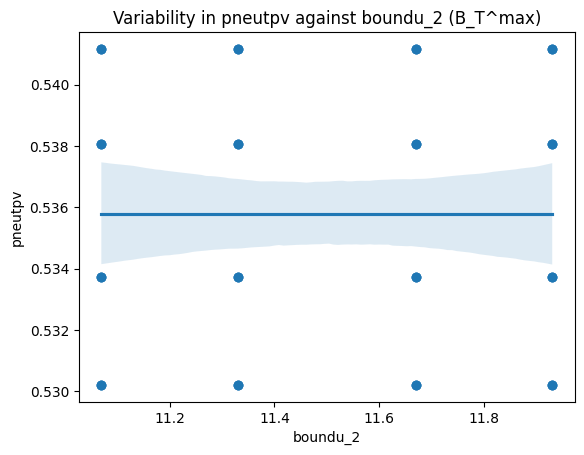

In [15]:
# Plot 2 vars from sample against each other
# Input epistemic uncertainty boundu_2 (B_T^max, maximum toroidal field)
# against `palph2()` input pneutpv (neutron fusion power per volume (MW/m3))
ax = sns.regplot(x=samples["boundu_2"], y=samples["pneutpv"])
ax.set_xlabel("boundu_2")
ax.set_ylabel("pneutpv")
ax.set_title("Variability in pneutpv against boundu_2 (B_T^max)")


## Analysis

Analyse `pneutpv`, an input argument to `palph2()`, and an output of this analysis.

### KDE for `pneutpv` from EasyVVUQ (plotted with seaborn)

Text(0, 0.5, 'Density')

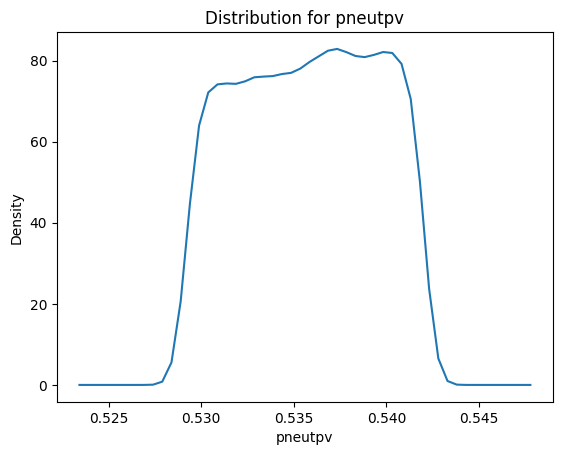

In [8]:
# Try to analyse all outputs variables: produces a linalg error
# results = campaign.analyse(qoi_cols=palph2_inputs)

# Analyse a single output variable, pneutpv
results = campaign.analyse(qoi_cols=["pneutpv"])

# Get its distribution
dist = results.get_distribution(qoi="pneutpv")

# Locations for density function to be evaluated
# (This is taken from easyvvuq's fusion tutorial)
x = np.linspace(dist.lower[0], dist.upper[0])
pdf = dist.pdf(x)

# Plot
ax = sns.lineplot(x=x, y=pdf, markers=True)
ax.set_title("Distribution for pneutpv")
ax.set_xlabel("pneutpv")
ax.set_ylabel("Density")
# Again, this is different on each run: something stochastic


PDF for `pneutpv`. Appears right from looking at the EasyVVUQ tutorial (fusion Dask).

QoIs are the inputs (arguments) for `palph2()`. These might not have any particularly interesting distributions: perhaps some are still only intervals (from the input epistemic uncertainties).

### KDE using seaborn alone

Seaborn can produce a KDE itself, using the raw sample data.

<AxesSubplot: ylabel='Density'>

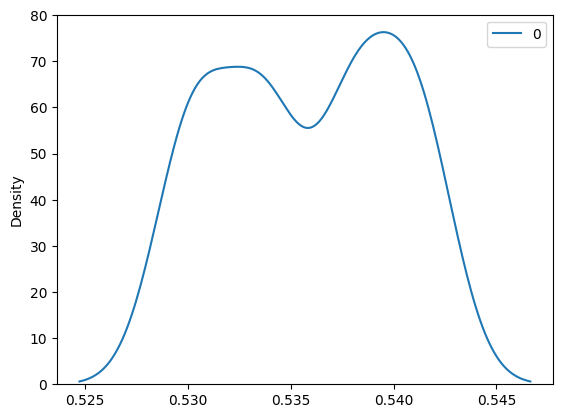

In [9]:
# Try a separate KDE with seaborn only
sns.kdeplot(results.samples["pneutpv"])


Seaborn's plot appears smoother and broader. Not sure which to use; inclined to use EasyVVUQ's chaospy distribution (from the EasyVVUQ tutorial).

### Correlation matrix (Correlogram)

Good for showing all possible relationships between variables in data.

Perhaps not much point in including inputs in this: inputs against inputs isn't very helpful or interesting, but can show the samples clearly.

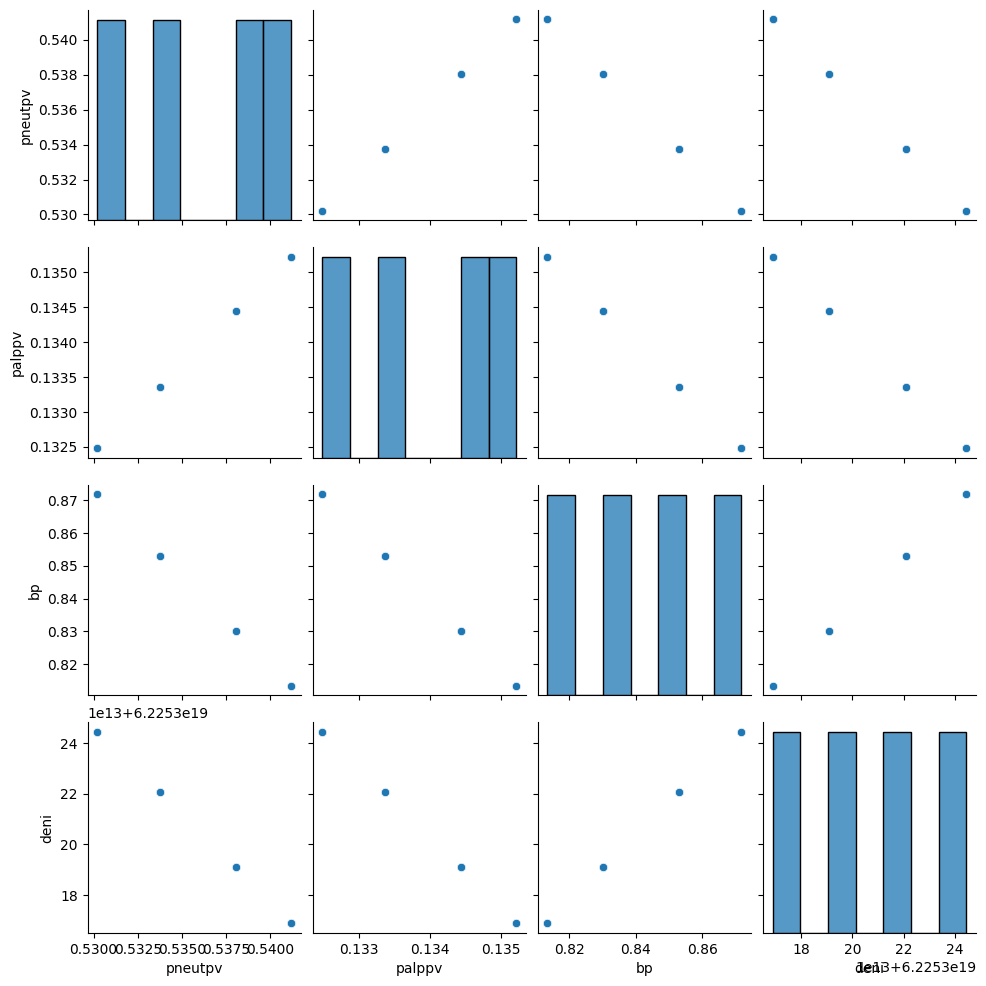

In [33]:
# Input epistemic uncertainties
# plot_list = list(vary.keys())

# pneutpv and palppv are outputs
plot_list = ["pneutpv", "palppv", "bp", "deni"]
sub_df = results.samples[plot_list]
# pairplot doesn't support MultiIndexed columns
sub_df.columns = sub_df.columns.droplevel(1)
sns.pairplot(sub_df, kind="scatter", diag_kind="hist")

# Attempting to plot entire results df (39 columns) takes >2 mins


This is just plotting samples, and isn't taking advantage of the analysis in EasyVVUQ. However, it's a good visualisation. Might want to choose some better variables to plot, but probably need to vary more input params first.